In [1]:
# %load ~/.ipython/standard_imports.py
import os
import sys
import logging
import itertools
import functools

logging.basicConfig(level=logging.INFO)
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing

import isajosep_util
import isajosep_util.data_frame_plotter

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


Attached CSV file contains a number of medical cases (extracted from EHRs). Each entry consists of:

- one more more “present” symptoms (symptoms that patient had at the time of visit). For example `s_0136` is GYANT code for “earache”.
- one more “absent” symptoms (symptoms that patient did not have). Keep in mind that there may other potential symptoms the patient was never asked about, which are neither “present” nor “absent”
- Age, Sex (1=Male), and Month of visit (which may be helpful, e.g. some conditions are gender-specific, some are seasonal)
- Diagnosis (“DX”) the patient was diagnosed with (using Gyant condition codes)


**This notebook does the initial data formatting and sanity-checking.**


Ultimately, our goal is to build a ML model that predicts the Diagnosis (DX), based on symptoms and other factors. In the project you can demonstrate doing some or all of the following:
- Perform exploratory analysis and visualization of data 
- Build one or more ML models on the data
- Select the best model, and report its performance and error analysis
- Perform feature selection to find most salient features
- Explore ways to deal with unbalanced data
- Try using external ML classifies (e.g. IBM Watson)
etc, etc

# Load

In [3]:
df = pd.read_csv('/Users/ijoseph/Code/Data/Gyant/data_challenge.csv', index_col=0)

# Cleaning

In [4]:
df.sample(5)

,DX,AGE,MONTH,SEX,Absent,Present
52869,c_0608,2.0,1,1,"s_0106, s_0002, s_0553, s_0180","s_0400, s_0542, s_0246, s_0084"
28319,c_0055,36.0,10,1,"s_0106, s_0242, s_2282, s_0084, s_0413, s_2222...",s_1302
23821,c_0008,25.0,10,0,"s_0106, s_0242, s_2282, s_1302, s_2253, s_0084...","s_0136, s_0374, s_0389, s_0777, s_0578, s_0620..."
30073,c_0036,37.0,9,0,"s_0070, s_0106, s_0553, s_1050, s_0002, s_0078...","s_0786, s_0864"
14708,c_0152,36.0,1,1,s_0084,"s_0445, s_0180"


In [5]:
df.shape

(71662, 6)

In [6]:
df.describe()

,AGE,MONTH,SEX
count,71662.000000,71662.000000,71662.000000
mean,32.297787,6.197357,0.407538
std,20.104694,3.531117,0.491380
min,-3.000000,1.000000,0.000000
25%,19.000000,3.000000,0.000000
50%,32.000000,6.000000,0.000000
75%,45.000000,9.000000,1.000000
max,161.000000,12.000000,1.000000


Hm, mostly reasonable except for some impossible values for `AGE`.

## `AGE` cleaning

In [7]:
df.query("AGE > 100")

,DX,AGE,MONTH,SEX,Absent,Present
1186,c_0273,102.0,8,0,"s_0070, s_0106, s_0039, s_0346, s_0519, s_0002...","s_0578, s_0120, s_0865, s_2563"
24878,c_0497,159.0,12,1,s_1298,"s_0210, s_1317, s_2194, s_2387, s_1316"
24893,c_0036,101.0,7,0,"s_0070, s_1047, s_0519, s_0078, s_0022, s_0062",NaN
44092,c_0720,161.0,1,0,s_0327,s_1216
47754,c_0608,102.0,4,0,"s_0400, s_0553, s_0826, s_0180","s_0022, s_2253, s_1030, s_0901, s_0460"
57856,c_0273,102.0,1,0,"s_0070, s_0864, s_0542, s_0039, s_0078","s_0578, s_0647, s_2738, s_1266"


In [8]:
df.query("AGE < 0")

,DX,AGE,MONTH,SEX,Absent,Present
14105,c_0273,-3.0,8,0,"s_2738, s_2282","s_2204, s_0578, s_0542, s_2563, s_1266"


Okay anything over 102.0 seems unlikely, and < 0 impossible. Want to assess whether missingness is correlated with anything else, rather than merely dropping these off the bat so as to not induce bias from dropping. 

In [9]:
df.query("(AGE > 103) or (AGE < 0) ")

,DX,AGE,MONTH,SEX,Absent,Present
14105,c_0273,-3.0,8,0,"s_2738, s_2282","s_2204, s_0578, s_0542, s_2563, s_1266"
24878,c_0497,159.0,12,1,s_1298,"s_0210, s_1317, s_2194, s_2387, s_1316"
44092,c_0720,161.0,1,0,s_0327,s_1216


Nothing obvious in terms of presence /absence of symptoms or DX, so safe to drop these, probably. 

In [10]:
df_age_cleaned = df.query("(AGE < 103) and (AGE > 0)")

## Missing/ Duplicated Values

Using custom helper function to check for both ([see repository here](https://github.com/ijoseph/util/blob/6d6cd84da663c39009d3894977f3e61c88d0969b/isajosep_util/__init__.py#L20))

In [11]:
isajosep_util.check_for_null(df_age_cleaned)

✗ 12,320 NaN or Inf values; 0 inf, 12,320 nan; Duplications: 185 duplicated rows by exclusively non-index content, 0 duplicated rows by exclusively index, 0 duplicated by both


(12320, 0, 12320, 185, 0, 0)

Okay, so several NaNs as expected via lack of check for absence or presence. 

Duplications are less expected. Looking more into these... 

### Duplicated by all columns other than index

In [12]:
df_age_cleaned[df_age_cleaned.duplicated(keep=False)].sort_values(by=['DX','AGE', 'MONTH', 'SEX']).head(10)

,DX,AGE,MONTH,SEX,Absent,Present
33339,c_0008,29.0,12,0,NaN,NaN
37010,c_0008,29.0,12,0,NaN,NaN
14403,c_0008,30.0,3,0,NaN,NaN
19340,c_0008,30.0,3,0,NaN,NaN
960,c_0008,30.0,6,1,NaN,NaN
59748,c_0008,30.0,6,1,NaN,NaN
29459,c_0008,31.0,1,1,NaN,NaN
53960,c_0008,31.0,1,1,NaN,NaN
32905,c_0008,31.0,6,0,NaN,NaN
49801,c_0008,31.0,6,0,NaN,NaN


In [13]:
df_age_cleaned_dedup = df_age_cleaned.drop_duplicates(subset=['DX', 'AGE', 'MONTH', 'Absent', 'Present'])

In [14]:
df_age_cleaned_dedup.shape, df_age_cleaned.shape

((69305, 6), (69646, 6))

### Duplicated by `DX`, `AGE`, `MONTH`, `SEX`

In [15]:
dup_subset = ['DX', 'AGE', 'MONTH', 'SEX']

In [16]:
isajosep_util.check_for_null(df_age_cleaned_dedup.drop(['Absent', 'Present'], axis='columns'))

✗ 0 NaN or Inf values; 0 inf, 0 nan; Duplications: 48,083 duplicated rows by exclusively non-index content, 0 duplicated rows by exclusively index, 0 duplicated by both


(0, 0, 0, 48083, 0, 0)

In [17]:
print("{:,} of {:,} rows are part of a duplication event!".format(df_age_cleaned_dedup.drop(['Absent', 'Present'], axis='columns').duplicated(keep=False).sum(), df_age_cleaned_dedup.shape[0]))

60,578 of 69,305 rows are part of a duplication event!


Okay, interesting in that lots of duplications when we get rid of those columns for some reason. Off the bat, seems like too many duplications to be by chance; how many people with the exact same age (to the month) and gender could there be receiving the same diagnosis? 

Therefore, we need to merge the `Absent` and `Present` columns for rows with duplicate values of `( DX, AGE, MONTH, SEX)`. The assumption here is that duplicate diagnoses are simply multiple entires of the same real-world diagnostic test, rather than duplicate relatively-independent real-world tests having been performed.

In [18]:
df_age_cleaned_dedup[df_age_cleaned_dedup.duplicated(subset=dup_subset, keep=False)].sort_values(dup_subset).head()

,DX,AGE,MONTH,SEX,Absent,Present
28287,c_0008,1.0,1,1,"s_0553, s_0180","s_0084, s_0443"
40964,c_0008,1.0,1,1,"s_0106, s_0542, s_0553, s_0363, s_0180",s_0084
1035,c_0008,2.0,5,1,"s_0434, s_0309, s_1141, s_0084, s_0180","s_0400, s_0445, s_0022, s_0826"
44996,c_0008,2.0,5,1,"s_0911, s_0180, s_0268, s_1141, s_0542, s_0826...",s_0084
52058,c_0008,2.0,6,1,NaN,"s_2194, s_0309, s_0826"


Can probalby fix this with [`groupby` and an `aggregate` function](https://stackoverflow.com/questions/36271413/pandas-merge-nearly-duplicate-rows-based-on-column-value). 

#### `aggregate` function

In [19]:
def combine_symptom_cells(cell_list):
    """
    Takes in a list of cells, each of which are comma-delim strings (or just NaN which need to be ignored). 
    
    Outputs a de-duplicated tuple of combined symptom codes. 
    
    Example: 
    ['s_0553, s_0180', np.nan,'s_0106, s_0542, s_0553, s_0363, s_0180'] -> 
    ('s_0363', 's_0106', 's_0180', 's_0542', 's_0553')    
    """
    
    # Parse from string to list of string by commas
    parsed = [ c.split(',') for c in cell_list if isinstance(c,str) ]
    
    # Flatten 
    parsed = [item for sublist in parsed for item in sublist]
    
    #Strip whitespace
    parsed = [s.strip() for s in parsed]
    
    # Remove duplciates
    parsed = tuple(set(parsed))
    
    return(parsed)    

##### Test

In [20]:
tst_arr = ['s_0553, s_0180', np.nan,'s_0106, s_0542, s_0553, s_0363, s_0180']

In [21]:
combine_symptom_cells(tst_arr)

('s_0542', 's_0106', 's_0363', 's_0180', 's_0553')

##### Use

In [22]:
df_aggregated = df_age_cleaned_dedup.groupby(dup_subset).aggregate(combine_symptom_cells).reset_index()

In [23]:
df_aggregated.shape

(21222, 6)

In [24]:
df_aggregated.sample(10)

,DX,AGE,MONTH,SEX,Absent,Present
3709,c_0056,68.0,8,0,(),"(s_0653, s_0628)"
20569,c_0720,18.0,10,1,"(s_0039, s_0180, s_0837, s_0653)","(s_1547,)"
17032,c_0499,45.0,8,0,(),"(s_2563, s_0148, s_0229, s_2742, s_0242, s_259..."
12749,c_0206,24.0,5,0,"(s_0519, s_0911, s_0327, s_0837, s_0356, s_086...","(s_0290, s_0084, s_0242, s_0691, s_0041)"
413,c_0008,31.0,9,1,"(s_0519, s_2755, s_0837, s_0826, s_0124, s_081...","(s_0309, s_2734, s_0178, s_0901, s_0443, s_065..."
14678,c_0273,74.0,4,0,"(s_0864, s_0022, s_2738)","(s_0519, s_0220, s_1211, s_1318, s_0120, s_062..."
19726,c_0655,12.0,3,0,"(s_0180, s_0837)","(s_1547, s_0553, s_2742)"
658,c_0008,42.0,1,1,"(s_0022, s_0424)","(s_0309, s_0242, s_0084, s_0826)"
21186,c_0720,84.0,7,1,"(s_0327,)",()
12496,c_0196,45.0,5,1,"(s_0519, s_1364, s_0434, s_0811, s_0327, s_082...","(s_0309, s_0120, s_2734, s_0290, s_0180, s_161..."


In [25]:
isajosep_util.check_for_null(df_aggregated)

✓ No Nan or Inf values; no duplications.


(0, 0, 0)

# Formatting

## Index by `[DX, AGE, MONTH, SEX]`.

In [26]:
df_aggregated.set_index(['DX', 'AGE', 'MONTH', 'SEX'], inplace=True)

In [27]:
df_aggregated.sample(3)

,,,,Absent,Present
DX,AGE,MONTH,SEX,,
c_0008,57.0,5,1,"(s_0309, s_1611, s_0180)","(s_1302, s_0084, s_0356, s_0445, s_0419, s_0864)"
c_0144,40.0,6,1,"(s_0542, s_0106, s_0180, s_1266, s_0837, s_008...","(s_0136,)"
c_0273,80.0,11,0,"(s_0070, s_2186, s_0363, s_0078, s_1141, s_0022)","(s_0084, s_1030)"


## Create flags for each symptom checked so as to be useful as features for ML modeling.  

Basic idea: for each patient, each symptom can have one of four states, each of which might have some diagnostic utility: 
1. Symptom not checked for* (`not_checked`)
2. Symptom checked for and present. (`checked_and_present`)
3. Symptom checked for and absent. (`checked_and_absent`)
4. Symptom checked for and (present AND absent)† (`checked_and_present_and_absent`) 

†The fourth option is contradictory at first glance, but potentially possible if symptoms checked at, for example, different times within a month and give different results on each check. 

*Option one is of interested because if symptom wasn't checked for, that might be of particular diagnostic value (perhaps the patient was unable to consent to the diagnostic, which is useful unformation in and of itself in terms of the pateint's verbal status, for example). 

Concrete encoding: 
For each symptom `A`, `sklearn` will convert to boolean indicators with the folowing meaning:


|Indicator   |  Meaning |
|---|---|
|`absentA`   |  $0$: Symptom not found in `Absent` column; $1$: symptom found in `Absent` column  |
|`presentA`   |  $0$: Symptom not found in `Present` column; $1$: sympton found in `Present` column  |


We will convert this to the four options above for interpretability: 

| `absentA` | `presentA` | $\Rightarrow$ *state*|
|---|---|---|
| 0| 0 | `not_checked` |
| 0 |1 | `checked_and_present` |
|1  | 0 | `checked_and_absent` |
| 1 | 1 | `checked_and_present_and_absent`|

In [28]:
binarizer = sklearn.preprocessing.MultiLabelBinarizer()
binarizer = binarizer.fit(df_aggregated.Absent + df_aggregated.Present) # fit on both present and absent classes

In [29]:
symptoms = binarizer.classes_.copy()

In [30]:
print (len(symptoms), "symptoms found")

745 symptoms found


In [31]:
absent_df = pd.DataFrame(binarizer.transform(df_aggregated.Absent), columns=binarizer.classes_, index=df_aggregated.index)

In [32]:
absent_df.sample()

,,,,s_0002,s_0003,s_0004,s_0006,s_0012,s_0013,s_0014,s_0019,s_0022,s_0023,s_0025,s_0034,s_0037,s_0039,s_0041,s_0047,s_0049,s_0051,s_0054,s_0055,s_0062,s_0066,s_0069,s_0070,s_0076,s_0077,s_0078,s_0079,s_0080,s_0081,s_0084,s_0085,s_0087,s_0094,s_0095,s_0097,s_0098,s_0103,s_0105,s_0106,s_0111,s_0116,s_0117,s_0118,s_0120,s_0124,s_0126,s_0131,s_0132,s_0133,s_0134,s_0136,s_0137,s_0142,s_0143,s_0144,s_0145,s_0147,s_0148,s_0149,s_0152,s_0162,s_0163,s_0171,s_0178,s_0180,s_0181,s_0195,s_0196,s_0205,s_0210,s_0211,s_0220,s_0222,s_0227,s_0229,s_0240,s_0242,s_0246,s_0250,s_0252,s_0253,s_0254,s_0256,s_0258,s_0260,s_0261,s_0262,s_0264,s_0268,s_0269,s_0270,s_0276,s_0278,s_0279,s_0280,s_0281,s_0283,s_0284,s_0285,s_0286,s_0287,s_0288,s_0289,s_0290,s_0291,s_0293,s_0295,s_0297,s_0299,s_0300,s_0302,s_0303,s_0309,s_0313,s_0315,s_0316,s_0318,s_0324,s_0325,s_0326,s_0327,s_0328,s_0332,s_0333,s_0334,s_0335,s_0336,s_0339,s_0340,s_0342,s_0343,s_0344,s_0345,s_0346,s_0350,s_0351,s_0352,s_0355,s_0356,s_0357,s_0358,s_0360,s_0362,s_0363,s_0364,s_0367,s_0368,s_0369,s_0374,s_0377,s_0378,s_0382,s_0383,s_0389,s_0390,s_0392,s_0400,s_0413,s_0416,s_0418,s_0419,s_0424,s_0427,s_0428,s_0429,s_0431,s_0433,s_0434,s_0437,s_0438,s_0443,s_0444,s_0445,s_0454,s_0456,s_0458,s_0459,s_0460,s_0461,s_0462,s_0465,s_0469,s_0477,s_0478,s_0479,s_0480,s_0486,s_0493,s_0496,s_0500,s_0501,s_0502,s_0503,s_0506,s_0508,s_0509,s_0511,s_0512,s_0514,s_0517,s_0518,s_0519,s_0526,s_0527,s_0528,s_0533,s_0534,s_0535,s_0537,s_0542,s_0543,s_0549,s_0550,s_0551,s_0553,s_0554,s_0555,s_0557,s_0559,s_0563,s_0564,s_0565,s_0567,s_0568,s_0569,s_0570,s_0571,s_0572,s_0573,s_0574,s_0576,s_0578,s_0580,s_0583,s_0585,s_0587,s_0590,s_0596,s_0600,s_0602,s_0605,s_0606,s_0607,s_0614,s_0620,s_0625,s_0628,s_0633,s_0634,...,s_1427,s_1429,s_1444,s_1445,s_1446,s_1448,s_1450,s_1452,s_1457,s_1458,s_1459,s_1460,s_1461,s_1470,s_1471,s_1483,s_1484,s_1486,s_1488,s_1491,s_1492,s_1501,s_1527,s_1529,s_1539,s_1540,s_1541,s_1542,s_1543,s_1547,s_1548,s_1549,s_1555,s_1564,s_1565,s_1570,s_1572,s_1580,s_1581,s_1583,s_1597,s_1598,s_1608,s_1609,s_1610,s_1611,s_1612,s_1613,s_1617,s_1618,s_1624,s_1626,s_1632,s_1635,s_1647,s_1664,s_1667,s_1671,s_1672,s_1674,s_1675,s_1676,s_1686,s_1688,s_1689,s_1696,s_1697,s_1698,s_1699,s_1717,s_1718,s_1719,s_1720,s_1721,s_1722,s_1723,s_1724,s_1730,s_1733,s_1740,s_1742,s_1743,s_1755,s_1756,s_1758,s_1759,s_1760,s_1768,s_1769,s_1770,s_1774,s_1776,s_1795,s_1796,s_1797,s_1798,s_1808,s_1812,s_1819,s_1821,s_1826,s_1829,s_1843,s_2145,s_2146,s_2151,s_2152,s_2160,s_2162,s_2164,s_2171,s_2172,s_2179,s_2182,s_2186,s_2193,s_2194,s_2197,s_2204,s_2205,s_2209,s_2211,s_2212,s_2214,s_2215,s_2220,s_2222,s_2231,s_2234,s_2235,s_2236,s_2237,s_2243,s_2248,s_2249,s_2250,s_2252,s_2253,s_2264,s_2270,s_2273,s_2274,s_2275,s_2276,s_2278,s_2279,s_2282,s_2292,s_2295,s_2298,s_2299,s_2305,s_2308,s_2312,s_2313,s_2314,s_2316,s_2318,s_2322,s_2324,s_2325,s_2326,s_2329,s_2337,s_2338,s_2342,s_2346,s_2349,s_2351,s_2353,s_2358,s_2364,s_2366,s_2367,s_2368,s_2369,s_2371,s_2387,s_2392,s_2394,s_2408,s_2412,s_2433,s_2434,s_2435,s_2442,s_2443,s_2453,s_2454,s_2457,s_2461,s_2462,s_2464,s_2465,s_2468,s_2469,s_2481,s_2489,s_2503,s_2508,s_2536,s_2542,s_2544,s_2546,s_2563,s_2565,s_2566,s_2570,s_2572,s_2582,s_2583,s_2584,s_2587,s_2588,s_2589,s_2591,s_2592,s_2594,s_2596,s_2597,s_2598,s_2599,s_2606,s_2622,s_2625,s_2626,s_2630,s_2631,s_2634,s_2638,s_2647,s_2648,s_2651,s_2664,s_2694,s_2695,s_2697,s_2708,s_2734,s_2738,s_2739,s_2740,s_2741,s_2742,s_2743,s_2747,s_2754,s_2755,s_2768,s_2770
DX,AGE,MONTH,SEX,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

`absent_df`: each column indicates whether sympton explicitly absent. 

In [33]:
present_df = pd.DataFrame(binarizer.transform(df_aggregated.Present), columns=binarizer.classes_, index=df_aggregated.index)

In [34]:
present_df.sample()

,,,,s_0002,s_0003,s_0004,s_0006,s_0012,s_0013,s_0014,s_0019,s_0022,s_0023,s_0025,s_0034,s_0037,s_0039,s_0041,s_0047,s_0049,s_0051,s_0054,s_0055,s_0062,s_0066,s_0069,s_0070,s_0076,s_0077,s_0078,s_0079,s_0080,s_0081,s_0084,s_0085,s_0087,s_0094,s_0095,s_0097,s_0098,s_0103,s_0105,s_0106,s_0111,s_0116,s_0117,s_0118,s_0120,s_0124,s_0126,s_0131,s_0132,s_0133,s_0134,s_0136,s_0137,s_0142,s_0143,s_0144,s_0145,s_0147,s_0148,s_0149,s_0152,s_0162,s_0163,s_0171,s_0178,s_0180,s_0181,s_0195,s_0196,s_0205,s_0210,s_0211,s_0220,s_0222,s_0227,s_0229,s_0240,s_0242,s_0246,s_0250,s_0252,s_0253,s_0254,s_0256,s_0258,s_0260,s_0261,s_0262,s_0264,s_0268,s_0269,s_0270,s_0276,s_0278,s_0279,s_0280,s_0281,s_0283,s_0284,s_0285,s_0286,s_0287,s_0288,s_0289,s_0290,s_0291,s_0293,s_0295,s_0297,s_0299,s_0300,s_0302,s_0303,s_0309,s_0313,s_0315,s_0316,s_0318,s_0324,s_0325,s_0326,s_0327,s_0328,s_0332,s_0333,s_0334,s_0335,s_0336,s_0339,s_0340,s_0342,s_0343,s_0344,s_0345,s_0346,s_0350,s_0351,s_0352,s_0355,s_0356,s_0357,s_0358,s_0360,s_0362,s_0363,s_0364,s_0367,s_0368,s_0369,s_0374,s_0377,s_0378,s_0382,s_0383,s_0389,s_0390,s_0392,s_0400,s_0413,s_0416,s_0418,s_0419,s_0424,s_0427,s_0428,s_0429,s_0431,s_0433,s_0434,s_0437,s_0438,s_0443,s_0444,s_0445,s_0454,s_0456,s_0458,s_0459,s_0460,s_0461,s_0462,s_0465,s_0469,s_0477,s_0478,s_0479,s_0480,s_0486,s_0493,s_0496,s_0500,s_0501,s_0502,s_0503,s_0506,s_0508,s_0509,s_0511,s_0512,s_0514,s_0517,s_0518,s_0519,s_0526,s_0527,s_0528,s_0533,s_0534,s_0535,s_0537,s_0542,s_0543,s_0549,s_0550,s_0551,s_0553,s_0554,s_0555,s_0557,s_0559,s_0563,s_0564,s_0565,s_0567,s_0568,s_0569,s_0570,s_0571,s_0572,s_0573,s_0574,s_0576,s_0578,s_0580,s_0583,s_0585,s_0587,s_0590,s_0596,s_0600,s_0602,s_0605,s_0606,s_0607,s_0614,s_0620,s_0625,s_0628,s_0633,s_0634,...,s_1427,s_1429,s_1444,s_1445,s_1446,s_1448,s_1450,s_1452,s_1457,s_1458,s_1459,s_1460,s_1461,s_1470,s_1471,s_1483,s_1484,s_1486,s_1488,s_1491,s_1492,s_1501,s_1527,s_1529,s_1539,s_1540,s_1541,s_1542,s_1543,s_1547,s_1548,s_1549,s_1555,s_1564,s_1565,s_1570,s_1572,s_1580,s_1581,s_1583,s_1597,s_1598,s_1608,s_1609,s_1610,s_1611,s_1612,s_1613,s_1617,s_1618,s_1624,s_1626,s_1632,s_1635,s_1647,s_1664,s_1667,s_1671,s_1672,s_1674,s_1675,s_1676,s_1686,s_1688,s_1689,s_1696,s_1697,s_1698,s_1699,s_1717,s_1718,s_1719,s_1720,s_1721,s_1722,s_1723,s_1724,s_1730,s_1733,s_1740,s_1742,s_1743,s_1755,s_1756,s_1758,s_1759,s_1760,s_1768,s_1769,s_1770,s_1774,s_1776,s_1795,s_1796,s_1797,s_1798,s_1808,s_1812,s_1819,s_1821,s_1826,s_1829,s_1843,s_2145,s_2146,s_2151,s_2152,s_2160,s_2162,s_2164,s_2171,s_2172,s_2179,s_2182,s_2186,s_2193,s_2194,s_2197,s_2204,s_2205,s_2209,s_2211,s_2212,s_2214,s_2215,s_2220,s_2222,s_2231,s_2234,s_2235,s_2236,s_2237,s_2243,s_2248,s_2249,s_2250,s_2252,s_2253,s_2264,s_2270,s_2273,s_2274,s_2275,s_2276,s_2278,s_2279,s_2282,s_2292,s_2295,s_2298,s_2299,s_2305,s_2308,s_2312,s_2313,s_2314,s_2316,s_2318,s_2322,s_2324,s_2325,s_2326,s_2329,s_2337,s_2338,s_2342,s_2346,s_2349,s_2351,s_2353,s_2358,s_2364,s_2366,s_2367,s_2368,s_2369,s_2371,s_2387,s_2392,s_2394,s_2408,s_2412,s_2433,s_2434,s_2435,s_2442,s_2443,s_2453,s_2454,s_2457,s_2461,s_2462,s_2464,s_2465,s_2468,s_2469,s_2481,s_2489,s_2503,s_2508,s_2536,s_2542,s_2544,s_2546,s_2563,s_2565,s_2566,s_2570,s_2572,s_2582,s_2583,s_2584,s_2587,s_2588,s_2589,s_2591,s_2592,s_2594,s_2596,s_2597,s_2598,s_2599,s_2606,s_2622,s_2625,s_2626,s_2630,s_2631,s_2634,s_2638,s_2647,s_2648,s_2651,s_2664,s_2694,s_2695,s_2697,s_2708,s_2734,s_2738,s_2739,s_2740,s_2741,s_2742,s_2743,s_2747,s_2754,s_2755,s_2768,s_2770
DX,AGE,MONTH,SEX,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

`present_df`: each column indicates whether symptom explicitly present.

In [35]:
pres_and_abs_df = present_df.join(absent_df, lsuffix="__present", rsuffix="__absent")

### Iterate through and create new DataFrame

For each column, loook up and create new vector (`not_checked`, `checked_and_present`, `checked_and_absent`, `checked_and_present_and_absent`) 

In [36]:
possibilities = ['not_checked', 'checked_and_present', 'checked_and_absent', 'checked_and_present_and_absent']

In [37]:
all_possible_symptoms_and_possibilites = ["{}__{}".format(symptom, status)  for (symptom,  status) in itertools.product(binarizer.classes_, possibilities)]

Create placeholder

In [38]:
indicator_df = pd.DataFrame(columns=all_possible_symptoms_and_possibilites, index=df_aggregated.index)

In [39]:
tqdm.tqdm_pandas(tqdm.tqdm_notebook())

| `absentA` | `presentA` | *state*|
|---|---|---|
| 0| 0 | `not_checked` |
| 0 |1 | `checked_and_present` |
|1  | 0 | `checked_and_absent` |
| 1 | 1 | `checked_and_present_and_absent`|

In [40]:
def convert(row, symptoms=symptoms, all_possible_symptoms_and_possibilites=all_possible_symptoms_and_possibilites):
    """
    Convert a row of a DataFrame containing colums with names `symtom`_present, `symptom`_absent for symptom in symptoms
    to a row with ['`symtom`__not_checked', `symptom`__'checked_and_present', `symtom`__'checked_and_absent', `symtom__'checked_and_present_and_absent']. 
    
    e.g. 
    
    s_0002__present    0
    s_0002__absent     1
    
    -> 

    s_0002__not_checked  0
    s_0002__checked_and_present 0 
    s_0002__checked_and_absent 1 
    s_0002__checked_and_present_and_absent 0    
    """
    
    result_series = pd.Series(data=[0]*len(all_possible_symptoms_and_possibilites), index=all_possible_symptoms_and_possibilites)        
    
    for symptom in symptoms:
        try:
            absent = row[symptom + "__absent"]
            present = row[symptom + "__present"]
        except KeyError:
            sys.stderr.write("Warning: symptom {} not found".format(symptom))
            continue

        if absent == 0 and present == 0:
            result_series["{}__not_checked".format(symptom)] = 1
        elif absent == 0 and present == 1:
            result_series["{}__checked_and_present".format(symptom)] = 1
        elif absent == 1 and present == 0:
            result_series["{}__checked_and_absent".format(symptom)] = 1
        elif absent == 1 and present == 1:
            result_series["{}__checked_and_present_and_absent".format(symptom)] = 1
        else:
            raise ValueError("Some issue with encoding; symptom = {}".format(symptom))    
    return result_series

#### Test

In [41]:
pres_and_abs_df.filter(like='s_0078').iloc[0,:]

s_0078__present    0
s_0078__absent     0
Name: (c_0008, 1.0, 1, 1), dtype: int64

In [42]:
convert(pres_and_abs_df.filter(like='s_0078').iloc[0,:], symptoms=['s_0078'], all_possible_symptoms_and_possibilites=[s for s in all_possible_symptoms_and_possibilites if s.startswith('s_0078') ])

s_0078__not_checked                       1
s_0078__checked_and_present               0
s_0078__checked_and_absent                0
s_0078__checked_and_present_and_absent    0
dtype: int64

In [43]:
%load_ext ipycache

/Users/ijoseph/anaconda/envs/py36/lib/python3.6/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/Users/ijoseph/anaconda/envs/py36/lib/python3.6/site-packages/ipycache.py:17: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils.traitlets import Unicode


In [45]:
%%cache converted.pkl converted
converted = pres_and_abs_df.progress_apply(func=convert, axis=1)

In [49]:
%%time
isajosep_util.check_for_null(converted)

✗ 0 NaN or Inf values; 0 inf, 0 nan; Duplications: 822 duplicated rows by exclusively non-index content, 0 duplicated rows by exclusively index, 0 duplicated by both
CPU times: user 14.7 s, sys: 1.1 s, total: 15.8 s
Wall time: 15.8 s


(0, 0, 0, 822, 0, 0)

Show me a random sample of 100 rows, 100 cols

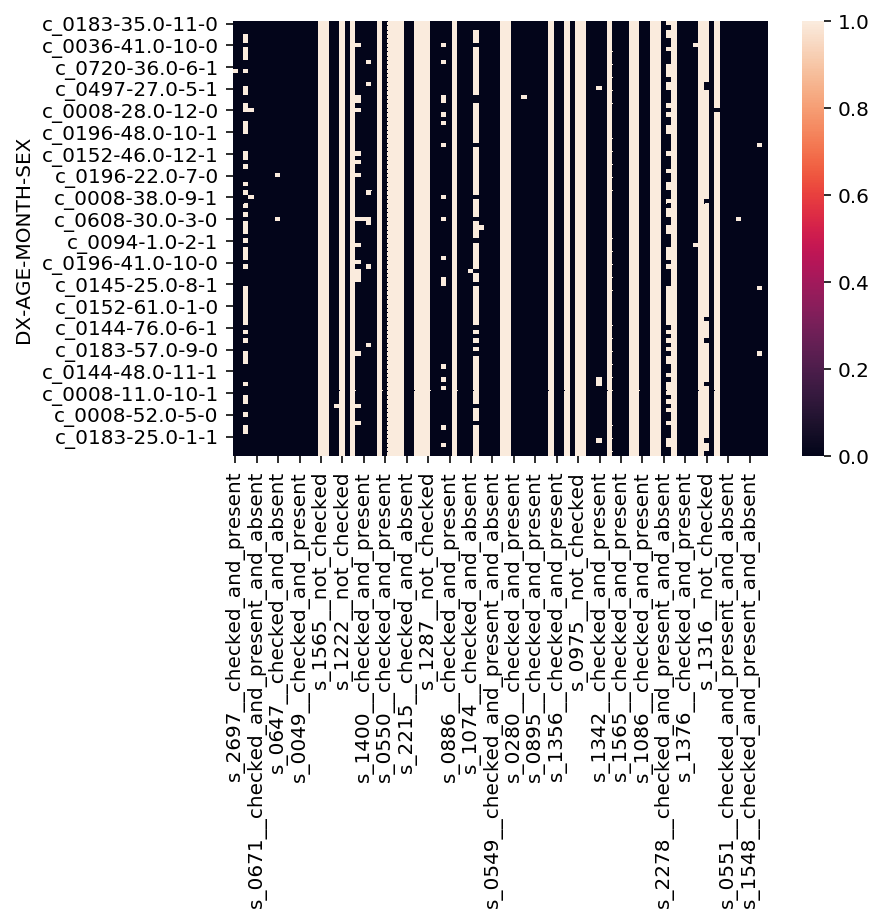

In [52]:
sns.heatmap(isajosep_util.double_sample_df(converted, row_dims=100, col_dims=100))

# Feature-engineering: add meta-features

Let's add total number of symptoms, total number of present symptoms, total number of absent symtpoms, total number of present_and_absent symptoms per patient. 

I see some constant columns. Remove those. 

In [95]:
def gen_meta_features(row, possibilities=possibilities):
    """
    Generate meta features based on sums across various features in the row for each possibility
    """

    row_s = pd.Series(index=['total_' + pos for pos in possibilities])
    
    for possibility in row_s.index:        
        row_s[possibility] = row.filter(like=possibility).sum()
    return row_s        

## Test

In [98]:
smpl = isajosep_util.double_sample_df(converted, row_dims=5, col_dims=5)

In [100]:
smpl.join(smpl.apply(func=gen_meta_features, axis=1))

s_1360__checked_and_absent  s_0864__checked_and_present  s_1175__checked_and_absent  s_0850__checked_and_present  s_0764__checked_and_absent  total_not_checked  total_checked_and_present  total_checked_and_absent  total_checked_and_present_and_absent
DX     AGE  MONTH SEX                                                                                                                                                                                                                                                            
c_0036 29.0 4     0                             0                            0                           0                            0                           0                0.0                        0.0                       0.0                                   0.0
c_0608 24.0 1     0                             0                            0                           0                            0                           0                0.0                        0.0                       0.0                                   0.0
       50.0 11    0                             0                            1                           0                            0                           0                0.0                        0.0                       0.0                                   0.0
c_0183 48.0 1     1                             0                            0                           0                            0                           0                0.0                        0.0                       0.0                                   0.0
c_0608 30.0 3     0                             0                            0                           0                            0                           0                0.0                        0.0                       0.0                                   0.0

## Use

In [103]:
converted_with_meta = converted.join(converted.progress_apply(func=gen_meta_features, axis=1))

In [104]:
converted_with_meta.to_pickle('/Users/ijoseph/Code/Data/Gyant/converted_with_meta.pkl')

# Remove No-Variance (not possibly predictive) columns

In [106]:
converted_no_const = converted_with_meta.loc[:,converted_with_meta.apply(pd.Series.nunique) != 1]

In [107]:
converted_no_const.shape

(21222, 2257)

Dropped a resonable number of columns

In [114]:
converted_no_const.reset_index('DX').to_pickle('/Users/ijoseph/Code/Data/Gyant/final_formatting_all_obs.pkl')